## OPC Response Function Demo

### Calculate POPS Response Function

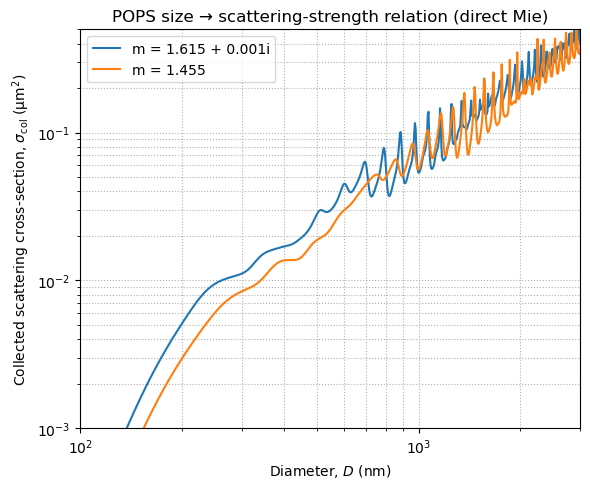

In [2]:
# Size–Csca relation (direct Mie, no LUT) using sigma_lut (no caches)
import sys
sys.path.append("/Users/C832577250/Research/SizeDistMerge/src")

import numpy as np
import matplotlib.pyplot as plt
from optical_diameter_core import POPSGeom, pops_csca, POPS_WAVELENGTH_NM

# --- geometry config (POPS geometry unchanged) ---
geom = POPSGeom(
    ring_theta_min_deg=38.0,
    ring_theta_max_deg=143.0,
    ring_step_deg=1.0,
    mirror_diameter_mm=25.0,
    distance_to_mirror_mm=14.3,
    pmt_aperture_d_mm=5.0,
    pmt_center_deg=90.0,
)

# --- diameter grid (nm) ---
D = np.logspace(np.log10(60), np.log10(6000), 1000)

# --- refractive indices to compare ---
m_list = [
    (1.615 + 0.001j, "m = 1.615 + 0.001i"),
    (1.455 + 0.0j,   "m = 1.455"),
]

wl = POPS_WAVELENGTH_NM

plt.figure(figsize=(6, 5))
for m_val, label in m_list:
    Ccol = pops_csca(D, m_val, wavelength_nm=wl, geom=geom)  # perpendicular enforced inside
    plt.loglog(D, Ccol, label=label)

plt.xlabel("Diameter, $D$ (nm)")
plt.ylabel(r"Collected scattering cross-section, $\sigma_{\mathrm{col}}$ (µm$^2$)")
plt.xlim(100, 3000)
plt.ylim(1e-3, 5e-1)
plt.title("POPS size → scattering-strength relation (direct Mie)")
plt.grid(True, which="both", linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()

### Read POPS response function from LUT and interpolate

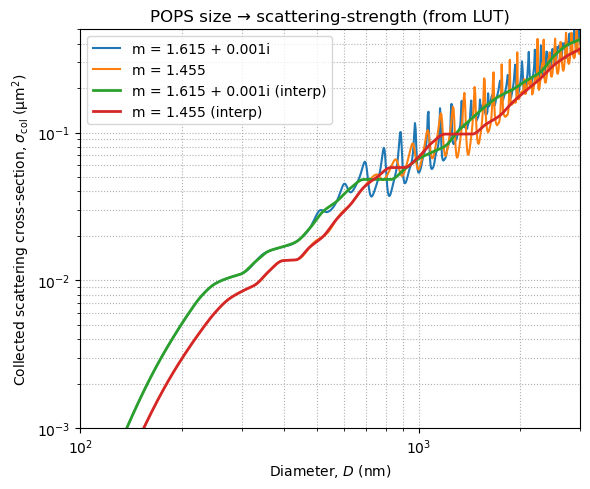

In [ ]:
# Size–σ_col relation USING LUT (clean, pops_sigma API)
import sys
sys.path.append("/Users/C832577250/Research/SizeDistMerge/src")

import numpy as np
import matplotlib.pyplot as plt
from optical_diameter_core import SigmaLUT, make_monotone_sigma_interpolator

OPC_RESPONSE_BINS = 50

# --- path to your LUT ---
zpath = "/Users/C832577250/Research/SizeDistMerge/lut/pops_sigma_col_405nm.zarr"

# --- open LUT & use its D-grid for best fidelity ---
lut = SigmaLUT(zpath)
D_plot = lut.Dg  # LUT diameters (nm)

# --- refractive indices to plot ---
m_list = [
    (1.615 + 0.001j, "m = 1.615 + 0.001i"),
    (1.455 + 0.0j,   "m = 1.455"),
    #(1.8 + 0.0j,   "m = 1.8"),
]

plt.figure(figsize=(6, 5))

# ---- original plot (unchanged): raw LUT curves ----
for m_val, label in m_list:
    n0 = float(np.real(m_val))
    k0 = float(np.imag(m_val))
    sigma = lut.sigma_curve(D_plot, n0, k0)  # trilinear in (D,n,k)
    plt.loglog(D_plot, sigma, label=label)

# ---- added overlay: smooth monotone σ(D) using isotonic + PCHIP ----
D_fine = np.geomspace(D_plot.min(), D_plot.max(), 1000)

for m_val, label in m_list:
    n0 = float(np.real(m_val))
    k0 = float(np.imag(m_val))
    sigma_raw = lut.sigma_curve(D_plot, n0, k0)

    # # Build monotone interpolator on log–log axes and evaluate on a fine grid
    f_sigma, g_diam = make_monotone_sigma_interpolator(
        D_plot, sigma_raw,
        response_bins=OPC_RESPONSE_BINS,         # fewer bins → smoother
    )
    
    sigma_smooth = f_sigma(D_fine)

    # match color of the original series by grabbing it from a dummy plot
    # (so legend shows both raw and interp distinctly)
    # Alternatively, you can skip the color logic and let matplotlib choose.
    line = plt.loglog(D_plot[:2], sigma_raw[:2], alpha=0)[0]
    color = line.get_color()
    plt.loglog(D_fine, sigma_smooth, linestyle="-", linewidth=2,
               color=color, label=f"{label} (interp)")

plt.xlabel("Diameter, $D$ (nm)")
plt.ylabel(r"Collected scattering cross-section, $\sigma_{\mathrm{col}}$ (µm$^2$)")
plt.xlim(100, 3000)        # optional: (D_plot.min(), D_plot.max())
plt.ylim(1e-3, 0.5)
plt.title("POPS size → scattering-strength (from LUT)")
plt.grid(True, which="both", linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()

### Calculate UHSAS Response Function

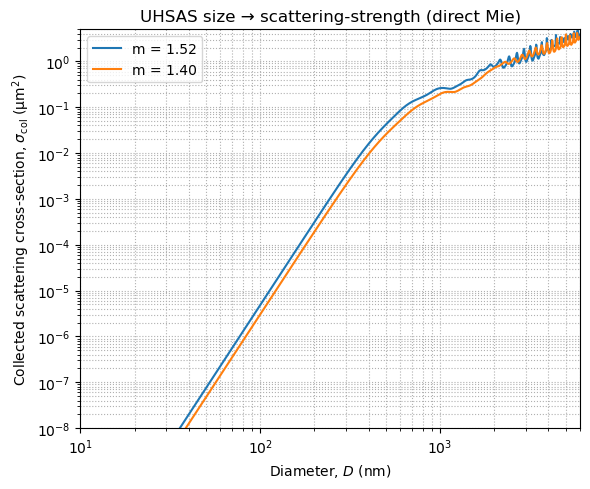

In [3]:
import sys
sys.path.append("/Users/C832577250/Research/SizeDistMerge/src")

import numpy as np
import matplotlib.pyplot as plt
from optical_diameter_core import UHSASGeom, uhsas_csca, UHSAS_WAVELENGTH_NM

# --- geometry config (POPS-style disk azimuth) ---
uhsas_geom = UHSASGeom(
    # integrate BIG band 33° → 147°
    big_theta_min_deg=33.0,
    big_theta_max_deg=147.0,
    # subtract SMALL exclusion 75.2° → 104.8°
    small_theta_min_deg=75.2,
    small_theta_max_deg=104.8,
    ring_step_deg=1.0,             # theta step (deg)
    aperture_distance_mm=8.0,      # L
    big_outer_halfangle_deg=57.0,  # sets BIG disk diameter: 2*L*tan(57°)
    inner_stop_halfangle_deg=14.8  # sets SMALL disk diameter: 2*L*tan(14.8°)
)

# --- diameter grid (nm) ---
D = np.logspace(np.log10(30), np.log10(6000), 1000)

# --- two refractive indices ---
m_list = [
    (1.52 + 0.0j, "m = 1.52"),
    (1.40 + 0.0j,   "m = 1.40"),
]

plt.figure(figsize=(6, 5))
for m_val, label in m_list:
    Ccol = uhsas_csca(
        D, m_val,
        wavelength_nm=UHSAS_WAVELENGTH_NM,   # UHSAS laser
        geom=uhsas_geom,        # polarization is enforced as perpendicular inside
    )
    plt.loglog(D, Ccol, label=label)

plt.xlabel("Diameter, $D$ (nm)")
plt.ylabel(r"Collected scattering cross-section, $\sigma_{\mathrm{col}}$ (µm$^2$)")
plt.xlim(10, 6000)
plt.ylim(1e-8, 5)
plt.title("UHSAS size → scattering-strength (direct Mie)")
plt.grid(True, which="both", linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()

### Read UHSAS response function from LUT and interpolate

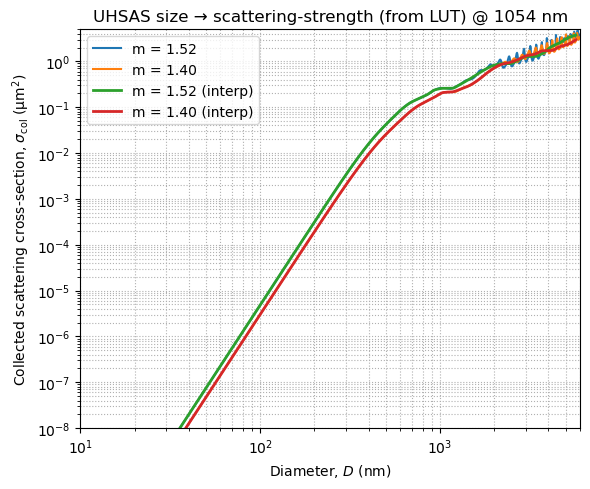

In [4]:
import sys
sys.path.append("/Users/C832577250/Research/SizeDistMerge/src")

import numpy as np
import matplotlib.pyplot as plt
from optical_diameter_core import SigmaLUT, make_monotone_sigma_interpolator

OPC_RESPONSE_BINS = 50

# --- path to your UHSAS LUT ---
zpath = "/Users/C832577250/Research/SizeDistMerge/lut/uhsas_sigma_col_1054nm.zarr"

# --- open LUT & use its D-grid for best fidelity ---
lut = SigmaLUT(zpath)
D_plot = lut.Dg  # LUT diameters (nm)

# --- refractive indices to plot ---
m_list = [
    (1.52 + 0.0j, "m = 1.52"),
    (1.40 + 0.0j,   "m = 1.40"),
]

plt.figure(figsize=(6, 5))

# ---- raw LUT curves ----
series_colors = []
for m_val, label in m_list:
    n0 = float(np.real(m_val))
    k0 = float(np.imag(m_val))
    sigma = lut.sigma_curve(D_plot, n0, k0)  # trilinear in (D,n,k)
    line = plt.loglog(D_plot, sigma, label=label)[0]
    series_colors.append(line.get_color())

# ---- smooth monotone σ(D) overlays (isotonic + PCHIP) ----
D_fine = np.geomspace(D_plot.min(), D_plot.max(), 1000)
for (m_val, label), color in zip(m_list, series_colors):
    n0 = float(np.real(m_val))
    k0 = float(np.imag(m_val))
    sigma_raw = lut.sigma_curve(D_plot, n0, k0)

    f_sigma, _ = make_monotone_sigma_interpolator(
        D_plot, sigma_raw,
        response_bins=OPC_RESPONSE_BINS,   # fewer bins → smoother
    )
    sigma_smooth = f_sigma(D_fine)

    plt.loglog(D_fine, sigma_smooth, linestyle="-", linewidth=2, label=f"{label} (interp)")

# --- cosmetics ---
plt.xlabel("Diameter, $D$ (nm)")
plt.ylabel(r"Collected scattering cross-section, $\sigma_{\mathrm{col}}$ (µm$^2$)")
# For UHSAS you can optionally show the nominal range; otherwise keep full-grid:
# plt.xlim(60, 1000)
plt.xlim(10, 6000)
plt.ylim(1e-8, 5)
title_lambda = getattr(lut, "wavelength_nm", None)
title_pol    = getattr(lut, "polarization", "").lower()
plt.title(f"UHSAS size → scattering-strength (from LUT)"
          + (f" @ {title_lambda:.0f} nm" if title_lambda else ""))
plt.grid(True, which="both", linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()